# Bayesian Inference Example
**Chris Mathys**

This is the example I use in my introductory lecture to Bayesian inference, developed for UCL's twice-yearly [SPM Courses](https://www.fil.ion.ucl.ac.uk/spm/course/).

We use [Julia](https://julialang.org/) and its probabilistic programming language [Turing.jl](https://turing.ml/).

In [1]:
# Setup
using Turing
using StatsBase
using DataFrames
using StatsPlots
using HypothesisTests
using Random
Random.seed!(1234)

TaskLocalRNG()

## The data

Two manufacturers, A and B, deliver the same kind of components. Your boss has bought a small sample from each and measured their lifetimes (in, say, days). Now he wants you to decide which manufucturer to buy from. He also tells you that the parts from B are more expensive, but if they live at least three days longer than those from A, buying from B ends up being cheaper. (Dataset created by simulation, adapted from an idea by Jaynes (1976)).

Lifetimes of parts from manufacturers A and B:


In [2]:
t = [59.6, 37.4, 47.6, 40.6, 48.6, 36.3, 31.5, 31.4, 45.7, 48.9, 48.7, 59.2, 51.9]


13-element Vector{Float64}:
 59.6
 37.4
 47.6
 40.6
 48.6
 36.3
 31.5
 31.4
 45.7
 48.9
 48.7
 59.2
 51.9

The first nine parts are from A (coded as 1), the last four from B (coded as 2).

In [3]:
m = [repeat([1] ,9); repeat([2], 4)]


13-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 2
 2
 2
 2

There are good reasons to analyze data that can only take positive values on a logarithmic scale. For example, if we simply applied a *t*-test to these two groups of observations, the implied model would allow for negative lifetimes, which doesn't make sense. Lifetimes are positive, so we log-transform them.

In [4]:
logt = log.(t)


13-element Vector{Float64}:
 4.087655574071304
 3.6216707044204863
 3.8628327612373745
 3.703768066607687
 3.883623530906448
 3.591817741270805
 3.449987545831587
 3.4468078929142076
 3.822098297900159
 3.8897773964808264
 3.885679030088544
 4.0809215418899605
 3.949318790171843

For easier interpretation and choice of priors, we standardize. That is, we subtract the mean of all data points from each point, so that the new mean is 0, then we divide by the standard deviation, so that the new standard deviation is 1. This is also called *Z-Scoring*. It means that the data are now on a scale that makes it easy to understand the meaning and properties of our parameters and their priors.

We save the parameters of our standardization in the variable `zed` so we can later use them to transform the results back to the observation scale.

In [5]:
zed = StatsBase.fit(ZScoreTransform, logt)
zlogt = StatsBase.transform(zed, logt)

13-element Vector{Float64}:
  1.3993688561978146
 -0.7947457447553727
  0.340778656400273
 -0.4081859381898525
  0.4386731037675281
 -0.9353100132422784
 -1.6031250496026244
 -1.6180966148751486
  0.14897826417477072
  0.46764890789431085
  0.4483515312475099
  1.36766130667277
  0.7480027343102971

## How *not* to analyze these data

First off, let's have a look at what happens when we reflexively apply recipes from classical statistics to this dataset instead of using probability theory (i.e., Bayesian inference). This is not intended as a takedown of classical statistics in general, whose methods - when correclty applied - can be just as valid as Bayesian ones. It is merely an illustration of the dangers of blindly applying conventional recipes. I will however say that the way classical statistics has been practiced encourages such a blind application, while Bayesian approaches force the user to lay open his assumptions and think about them carefully.

What classical recipe would be the most common on to use here? I would say the *t*-test. But which *t*-test? The one for equal variances or the one for unequal ones? The recipe for finding that out is the *F*-test. So let's do that.

In [6]:
VarianceFTest(logt[1:9], logt[10:13])

Variance F-test
---------------
Population details:
    parameter of interest:   variance ratio
    value under h_0:         1.0
    point estimate:          5.52273

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1874

Details:
    number of observations: [9, 4]
    F statistic:            5.52273099309121
    degrees of freedom:     [8, 3]


There is no significant difference between variances. Therefore, we use the *t*-test for equal variances.

In [7]:
EqualVarianceTTest(logt[1:9], logt[10:13])

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.232506
    95% confidence interval: (-0.482, 0.01703)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0649

Details:
    number of observations:   [9,4]
    t-statistic:              -2.050747714393771
    degrees of freedom:       11
    empirical standard error: 0.11337629452434277


So there is also no significant difference in the means of the two samples. Perhaps the scientific thing to do would be to go back to the boss and tell him that there is no difference in average lifetimes between manufacturers A and B, and that we should therefore just buy from A since their parts are cheaper.

Can we do better, though? Yes - we can use probability theory (i.e., Bayesian inference) to answer the relevant question directly. However, in order to do that, we cannot simply apply a recipe. Instead, we need to specify a model, justify it using first principles and prior predictive simulation, determine the posterior distribution, and finally get our answer by looking at the posterior predictive distribution.

## The model

### Structure

We choose a simple model where log-lifetimes from each manufacturer have their particular mean and standard deviation. This corresponds to the minimally constrainging assumption that manufacturers differ both in the overall quality of their parts and in the consistency of that quality. For example, a manufacturer's parts may be of high quality on average (high mean log-lifetime) but also highly variable (high standard deviation of log-lifetimes).

In [8]:
@model function gaussians(y, c, α_μ = 0, α_σ = 1, θ = 1)
    # Number of categories
    nc = length(unique(c))
    
    # Priors
    α ~ filldist(Normal(α_μ, α_σ), nc)
    σ ~ filldist(Exponential(θ), nc)
    
    # Observations
    # y .~ Normal.(α[c], σ[c])
    # The above works for inference, but not for predictive sampling.
    # For that to work, we need to use a loop.
    for i in eachindex(y)
        y[i] ~ Normal(α[c[i]], σ[c[i]])
    end 
end

gaussians (generic function with 8 methods)

We call the model `gaussians` because its parameters are the mean and standard deviation of a set of Gaussian distributions, each corresponding to a different category (manufacturers in our example).

The model takes five arguments: a vector of observations (log-lifetimes in our example), a vector of category indices (1 for manufacturer A, 2 for B), and three *hyperparameters*. These are parameters which specify the priors on the parameters. We need two hyperparameters to specify the prior on the means of the categories and one to specify the prior on their standard deviations. The defaults for the hyperparameters are chosen so that they should work well with standardized data. Since our data are standardized, a good first choice is to go with these defaults.

### Justification

If the following remarks are too technical, just ignore them. Note only that we didn't just choose this model for convenience. We have a substantial justification for all assumptions that went into it.

We can justify our choice of a Gaussian model from first principles. The minimal assumptions we can make are that parts from a given manufacturer will on average have a certain level of quality but will also have some variation around that level. No further assumptions are warranted based on the information we have. Given this, the Gaussian is the *maximum entropy* distribution of log-lifetimes, i.e. the one introducing the least assumptions. Another legitimate choice would have been a gamma model of lifetimes directly, without log-transforming them, because the gamma is the maximum entropy distribution for positive quantities. However, the gamma distribution is less intuitive in its properties, its parameters are harder to interpret, standardization by Z-scoring doesn't work because it leads to negative values, and specifying appropriate priors is therefore much harder.

For the Gaussians' standard deviation, we use an exponential prior. This only has one parameter, $\theta$, with an expectation of $1/\theta$ and a variance of $1/\theta^2$. It is an appropriate prior distribution for positive quantities about which we do not have enough information to make strong assumptions. So the only assumption we make is about their scale $\theta$.

# Prior predictive simulation

We can only really understand the implications of the assumptions in our model by simulating data from it. In particular, to understand the implications of our choice of priors, we need to simulate data from them. If the distribution of these simulated data make sense in light of everything we know, then we have an appropriate model, including appropriate priors.

In our case, we test this by creating eight fictitious manufacturers characterized by parameters (mean and precision of standardized log-lifteime) drawn randomly from the model's priors. Then we randomly draw 8,000 observations (standardized log-lifetimes) from each manufacturer's distribution.

We do this by first specifying the *design* for a single simulated manufacturer:

In [9]:
prior_predictive_design = gaussians(repeat([missing], 8_000), repeat([1], 8_000), 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Missing}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [missing, missing, missing, missing, missing, missing, missing, missing, missing, missing  …  missing, missing, missing, missing, missing, missing, missing, missing, missing, missing], c = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())


A remark on terminology: what I've just called a design is conventionally called a model, as in `model1 = gaussians(...)`. However, this terminology is misleading. The name model should be reserved for the specification of how parameters and observations relate to each other, as in `@model function ... end`. Varying structures of datasets to which the model is applied should go by a different name, e.g. design. In the course of this example, we will only use a single model: `gaussians` as defined above, with a choice of hyperparameters based on prior predictive simulation. However, we will use this same model with three different designs. We have one design for prior predictive simulation, one for fitting to the data, and one for posterior predictive simulation.

After defining our prior predictive design, we take eight samples corresponding to eight fictitious manufacturers:

In [10]:
prior_predictive_sample = sample(prior_predictive_design, Prior(), 8);

Sampling   0%|                                          |  ETA: N/A
Sampling  12%|█████▎                                    |  ETA: 0:00:07
Sampling  25%|██████████▌                               |  ETA: 0:00:03
Sampling  38%|███████████████▊                          |  ETA: 0:00:02
Sampling  50%|█████████████████████                     |  ETA: 0:00:01
Sampling  62%|██████████████████████████▎               |  ETA: 0:00:01
Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:01
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:01
Sampling 100%|██████████████████████████████████████████| Time: 0:00:01


We now need to do a bit of manipulation on our simulated data in order to arrange the eight samples of predicted log-lifetimes as the columns of an 8000-by-8 matrix. 

In [11]:
# Extract simulated observations into a dataframe
prior_predictive_y = DataFrame(prior_predictive_sample)[:, r"y"]

8×8000 DataFrame
 Row │ y[1]       y[2]        y[3]        y[4]        y[5]        y[6]       y ⋯
     │ Float64    Float64     Float64     Float64     Float64     Float64    F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.251194  -0.0576515  -0.108423   -0.296427    0.16944    -0.124633  - ⋯
   2 │ -0.286177  -0.919727   -0.67079     0.300402   -1.10795    -0.471356  -
   3 │ -0.577673   0.0720822  -0.548444    0.138491   -0.575404   -0.464491
   4 │ -0.450076  -0.362832   -0.47906    -0.505515   -0.44165    -0.477769  -
   5 │  0.888642   0.931901    0.994961    0.785284    0.971339    1.10672     ⋯
   6 │ -0.583117  -0.22884    -0.0839557  -0.410102   -0.675817   -0.5533    -
   7 │  0.15574    0.156725    0.234287    0.0452213   0.0539198   0.170204
   8 │  0.745734   0.631765   -0.144154    0.076423    0.329614    0.271461
                                                            7994 columns omitted

In [12]:
# Index observations by category (i.e., manufacturer in our example) instead of interpretation
prior_predictive_y = permutedims(prior_predictive_y, [:y1, :y2, :y3, :y4, :y5, :y6, :y7, :y8]) 

8000×8 DataFrame
  Row │ y1          y2         y3          y4         y5        y6          y7 ⋯
      │ Float64     Float64    Float64     Float64    Float64   Float64     Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.251194   -0.286177  -0.577673   -0.450076  0.888642  -0.583117   0. ⋯
    2 │ -0.0576515  -0.919727   0.0720822  -0.362832  0.931901  -0.22884    0.
    3 │ -0.108423   -0.67079   -0.548444   -0.47906   0.994961  -0.0839557  0.
    4 │ -0.296427    0.300402   0.138491   -0.505515  0.785284  -0.410102   0.
    5 │  0.16944    -1.10795   -0.575404   -0.44165   0.971339  -0.675817   0. ⋯
    6 │ -0.124633   -0.471356  -0.464491   -0.477769  1.10672   -0.5533     0.
    7 │ -0.231697   -0.294095   0.0810865  -0.47571   1.08863   -0.38793    0.
    8 │ -0.101377   -0.279126  -0.322627   -0.43852   0.875969   0.0972794  0.
  ⋮   │     ⋮           ⋮          ⋮           ⋮         ⋮          ⋮          ⋱
 7994 │ -0.205424   -0.757667   0.51809    -0.437341  1.15868   -0.391225   0. ⋯
 7995 │ -0.408904   -0.753442  -0.123214   -0.429602  0.960909  -0.265263   0.
 7996 │ -0.0618938  -0.618001  -0.253084   -0.406209  1.22799   -0.192388   0.
 7997 │ -0.222811   -0.773532  -0.0785421  -0.49063   0.815498  -0.255988   0.
 7998 │  0.170094   -0.709958   0.298465   -0.475521  0.767061  -0.410079   0. ⋯
 7999 │  0.071167   -0.737022   0.0400487  -0.506769  1.18193   -0.37792    0.
 8000 │ -0.300094   -0.990223  -0.0213454  -0.46257   0.626176  -0.571635   0.
                                                 2 columns and 7985 rows omitted

In [13]:
# Summarize simulated observations
describe(prior_predictive_y)

8×7 DataFrame
 Row │ variable  mean         min         median       max        nmissing  el ⋯
     │ Symbol    Float64      Float64     Float64      Float64    Int64     Da ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ y1        -0.179178    -0.871487   -0.181347     0.428022         0  Fl ⋯
   2 │ y2        -0.443972    -1.7165     -0.448796     0.728438         0  Fl
   3 │ y3        -0.00361845  -1.35832    -0.00280625   1.36881          0  Fl
   4 │ y4        -0.474713    -0.652686   -0.474756    -0.307134         0  Fl
   5 │ y5         0.888533    -0.14591     0.891053     1.82272          0  Fl ⋯
   6 │ y6        -0.286644    -0.9787     -0.286367     0.585384         0  Fl
   7 │ y7         0.151564    -0.0340219   0.151738     0.321861         0  Fl
   8 │ y8         0.343172    -0.740225    0.346018     1.50278          0  Fl
                                                                1 column omitted

In [14]:
# Go back from dataframe to matrix
prior_predictive_y = Matrix(prior_predictive_y)

8000×8 Matrix{Float64}:
 -0.251194   -0.286177  -0.577673   …  -0.583117   0.15574     0.745734
 -0.0576515  -0.919727   0.0720822     -0.22884    0.156725    0.631765
 -0.108423   -0.67079   -0.548444      -0.0839557  0.234287   -0.144154
 -0.296427    0.300402   0.138491      -0.410102   0.0452213   0.076423
  0.16944    -1.10795   -0.575404      -0.675817   0.0539198   0.329614
 -0.124633   -0.471356  -0.464491   …  -0.5533     0.170204    0.271461
 -0.231697   -0.294095   0.0810865     -0.38793    0.0448995   0.133657
 -0.101377   -0.279126  -0.322627       0.0972794  0.193737    0.522758
 -0.323505   -0.390759  -0.0998631     -0.453695   0.157877    0.236533
 -0.0291256  -0.307905   0.0198127     -0.104579   0.182838    0.843941
  ⋮                                 ⋱   ⋮                     
 -0.145775   -0.757348   0.811618      -0.323773   0.200064    0.867213
 -0.343508   -0.121291  -0.223759      -0.0399324  0.102216    0.540353
 -0.205424   -0.757667   0.51809       -0.391225 

### Visual sanity checks

We are now in a position to apply some sanity checks to the simulated data. What we want to see is a reasonable though not excessive amount of variation of stnadardized log-lifetimes within and between the different manufacturers.

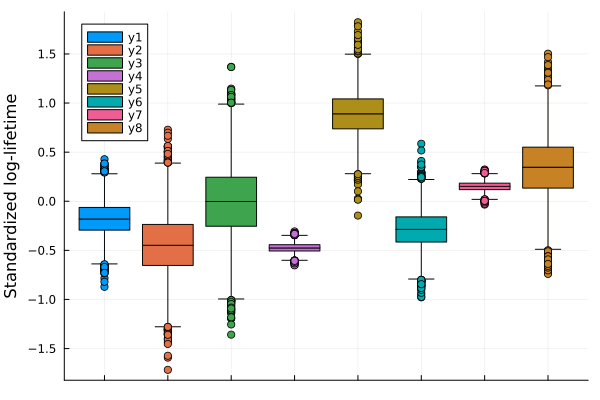

In [15]:
boxplot(prior_predictive_y, ylabel = "Standardized log-lifetime", xticks = (1:8, repeat([""], 8)))

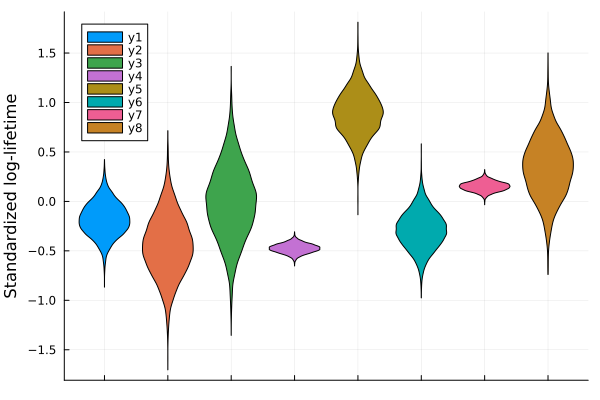

In [16]:
violin(prior_predictive_y, ylabel = "Standardized log-lifetime", xticks = (1:8, repeat([""], 8)))

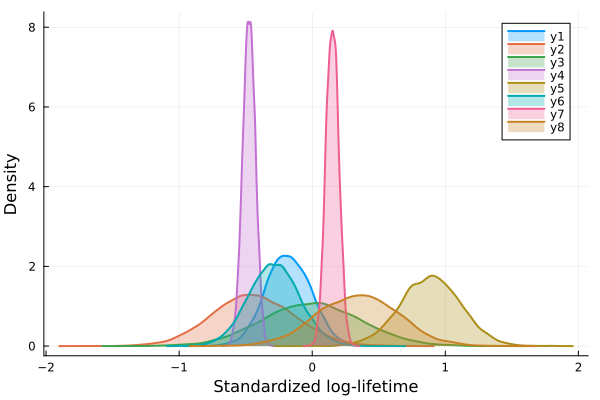

In [17]:
density(prior_predictive_y, ylabel = "Density", xlabel = "Standardized log-lifetime", linewidth = 2, fill = (0, 0.3))

This all looks fine, but it's not yet on the scale we're really interested in - the observation scale. We get to that scale by applying the inverse transformations in reverse order: first, we undo the standardization to get log-lifetimes, then we undo the log-scaling by exponentiating.

In [18]:
# Stack for easier handling
prior_predictive_y_stacked = vec(prior_predictive_y) 

64000-element Vector{Float64}:
 -0.2511936848640643
 -0.05765148327917237
 -0.10842343818660267
 -0.2964268670515061
  0.16944035225754622
 -0.12463346637024406
 -0.23169693763925184
 -0.10137741190442287
 -0.3235052445221479
 -0.02912557999286325
  ⋮
  0.8672133422012571
  0.5403526053722414
  0.615440527998709
  0.341643243399933
  0.36823363433190676
  0.10088854667962532
  0.03071263595355672
  0.35535148665838157
  0.41788207951204537

In [19]:
# Map to observation space
prior_predictive_lifetime_stacked = exp.(StatsBase.reconstruct(zed, prior_predictive_y_stacked))

64000-element Vector{Float64}:
 41.97650245104269
 43.73787292692718
 43.268784547111075
 41.57518178621527
 45.89903188784088
 43.12008021513204
 42.15067526663978
 43.33358177834454
 41.33677362881438
 44.003655060077186
  ⋮
 53.23077329241438
 49.66091316952636
 50.459210682424306
 47.60874113917499
 47.878360323803165
 45.23562905528552
 44.56643993181075
 47.74754877377867
 48.38587558828918

In [20]:
# Unstack
prior_predictive_lifetime = reshape(prior_predictive_lifetime_stacked, 8_000, 8)

8000×8 Matrix{Float64}:
 41.9765  41.6658  39.1646  40.2404  53.4736  39.1193  45.7657  51.875
 43.7379  36.4203  44.9597  40.993   53.9671  42.1763  45.7752  50.6345
 43.2688  38.3977  39.4084  39.9935  54.6947  43.4942  46.5355  42.9417
 41.5752  47.1936  45.5983  39.7694  52.3126  40.5835  44.704   45.0012
 45.899   34.9932  39.1834  40.3125  54.421   38.3567  44.7866  47.4873
 43.1201  40.059   40.1174  40.0044  56.0084  39.3678  45.9065  46.9044
 42.1507  41.5958  45.0458  40.0219  55.7937  40.775   44.7009  45.5515
 43.3336  41.7282  41.3445  40.3393  53.3299  45.201   46.1365  49.4757
 41.3368  40.7505  43.3475  40.7032  55.2375  40.2095  45.7865  46.5577
 44.0037  41.474   44.4634  40.2386  54.0675  43.3041  46.0298  52.9683
  ⋮                                            ⋮                
 42.9269  37.6982  52.606   39.3502  47.3083  41.3344  46.1985  53.2308
 41.1615  43.1507  42.2218  40.2775  54.2886  43.9028  45.2484  49.6609
 42.3865  37.6957  49.4267  40.3494  56.63    40

Now that we're on the observation scale, we can repeat our sanity checks here.

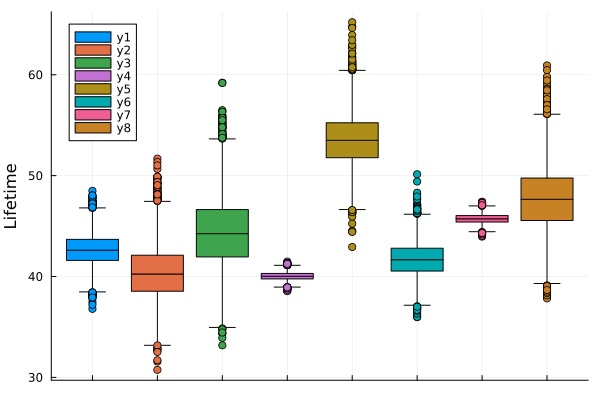

In [21]:
boxplot(prior_predictive_lifetime, ylabel = "Lifetime", xticks = (1:8, repeat([""], 8)))


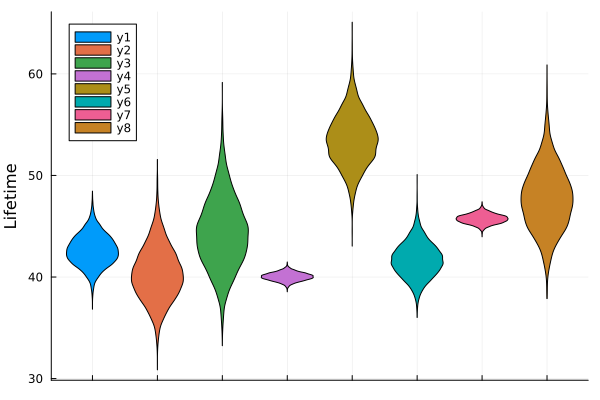

In [22]:
violin(prior_predictive_lifetime, ylabel = "Lifetime", xticks = (1:8, repeat([""], 8)))


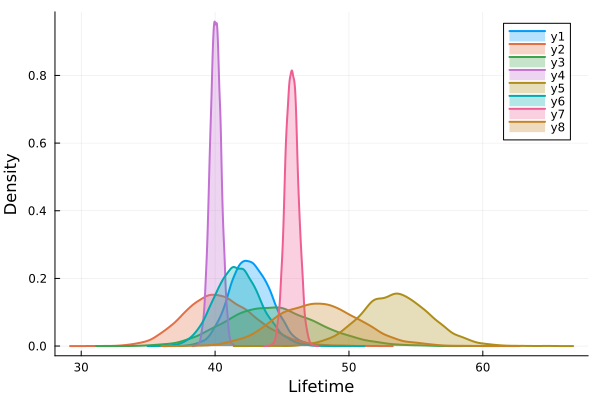

In [23]:
density(prior_predictive_lifetime, ylabel = "Density", xlabel = "Lifetime", linewidth = 2, fill = (0, 0.3))

We can see that there is a fair amount of variation of lifetimes both between and within simulated manufacturers while almost none of the simulated lifetimes is entirely outside the plausible range. So we are happy with our choice of priors. What is plausible depends entirely on our background knowledge of how the world works. The data alone cannot tell us this, and as opposed to our choice of model structure, we cannot justify our choice of hyperparameters (i.e., priors, which is what we're checking here) from first principles. All we can do is argue that our prior predictive distribution makes sense. It is the best summary of our modelling assumptions. As an exercise, you can ask yourself what the implied prior predictive distribution of a *t*-test is and whether that distribution makes sense.

(Answer: a *t*-test on lifetimes implies a prior predictive distribution that assigns the same probability to a lifetime of 50, which is plausible, as to one of 50 million, which is absurd, or of -50 million, which is impossible. In other words, almost all of the *t*-test's implied prior probability mass is outside the plausible range and much of it even in an impossible region. That doesn't make sense.)

As a second exercise, you can play around with the priors by choosing different hyperparameters and see how far you can go until the prior predictive distribution becomes unreasonable.

## Inference

### Posterior distribution

Our data design consists of the model applied to the data we're analyzing: the vector of standardized log-lifetimes and the vector of manufacturer indices.

In [24]:
data_design = gaussians(zlogt, m, 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Float64}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [1.3993688561978146, -0.7947457447553727, 0.340778656400273, -0.4081859381898525, 0.4386731037675281, -0.9353100132422784, -1.6031250496026244, -1.6180966148751486, 0.14897826417477072, 0.46764890789431085, 0.4483515312475099, 1.36766130667277, 0.7480027343102971], c = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())

Using this design with our chosen model, we sample from the posterior distribution. This gives us estimates of the mean and precision of the standardized log-lifetimes for manufacturers A and B.

In [25]:
posterior_sample = sample(data_design, NUTS(), 8_000, n_chains = 4)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/xm/.julia/packages/Turing/m3TxO/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:08:46
Sampling   1%|▍                                         |  ETA: 0:04:22
Sampling   2%|▋                                         |  ETA: 0:02:54
Sampling   2%|▉                                         |  ETA: 0:02:10
Sampling   2%|█                                         |  ETA: 0:01:44
Sampling   3%|█▎                                        |  ETA: 0:01:26
Sampling   4%|█▌                                        |  ETA: 0:01:13
Sampling   4%|█▋                                        |  ETA: 0:01:04
Sampling   4%|█▉                                        |  ETA: 0:00:57
Sampling   5%|██▏                                       |  ETA: 0:00:51
Sampling   6%|██▎                                       |  ETA: 0:00:46
Sampling   6%|██

Chains MCMC chain (8000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:9000
Number of chains  = 1
Samples per chain = 8000
Wall duration     = 3.18 seconds
Compute duration  = 3.18 seconds
parameters        = α[1], α[2], σ[1], σ[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        α[1]   -0.2554    0.2570    0.0029   7768.6159   5367.4973    1.0000   ⋯
        α[2]    0.6394    0.2079    0.0029   5942.1265   3977.2329    1.0000   ⋯
        σ[1]    0.8858    0.1788    0.0020   8186.2973   5390.1644    1.0006   ⋯
        σ[2]    0.4279    0.1508    0.0021   5753.8127   4301.1148    1.0004   ⋯
                                                   

The diagnostics of these samples ("chains" in the jargon) look good. The `rhat` values are close to 1 and the effect sample sizes (`ess_bulk` and `ess_tail`) are reasonably large (chains without any autocorrelation would have a value of 8,000). (Note that for the prior predictive sample, the same diagnostics are not interpretable because they are calculated across instead of within categories - a limitation of how prior predictive simulation is implemented here).

In addition to the numeric diagnostic values above, we plot our chains to get a visual impression: 

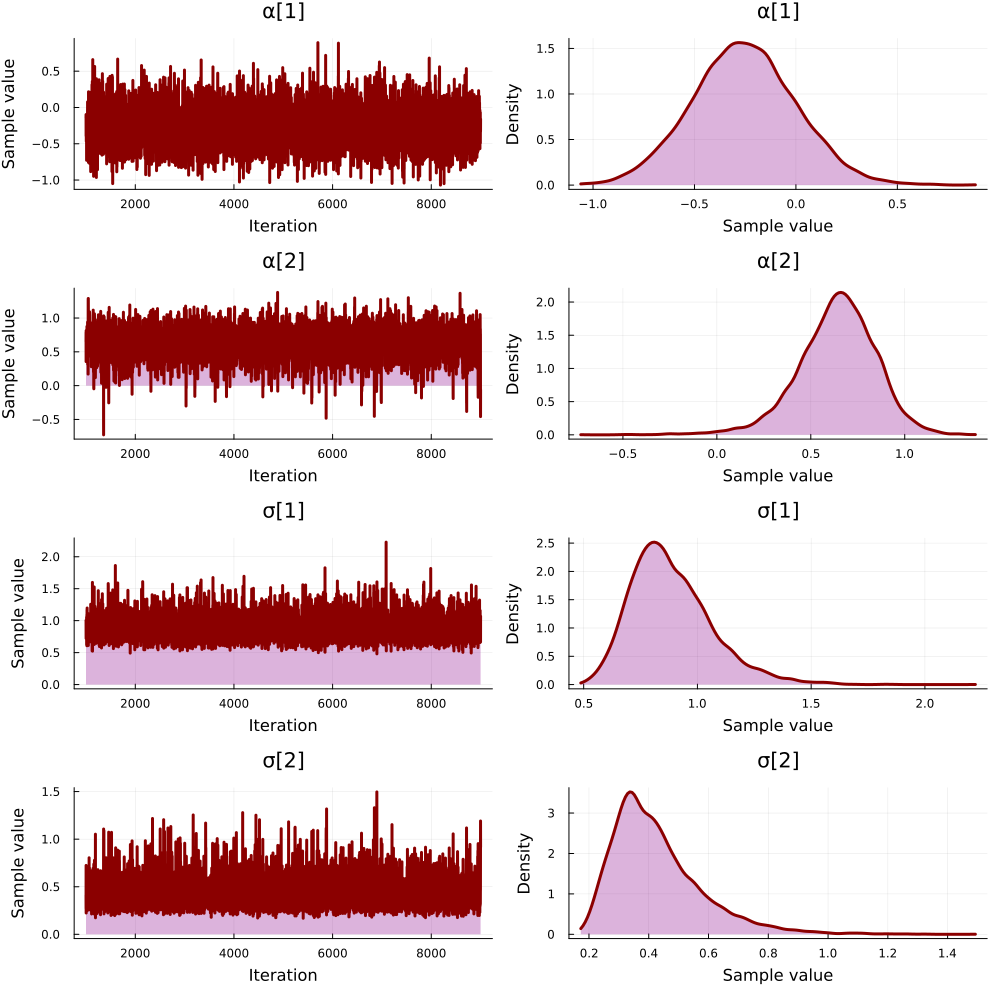

In [26]:
plot(posterior_sample, linewidth = 3, color = :darkred, fill = (0, 0.3, :darkmagenta))

All chains look healthy.

### Comparison of posterior means

When the boss said it would be worth buying from manufacturer B if their parts lived at least three days longer, what did he mean, exactly? Would the *median lifetime* of parts from B have to be three days longer, or would the *predicted lifetime difference* of randomly chosen part from each manufacturer have to be at least three days? He wasn't clear about that, but these are two very different things. The first is a question about the posterior distribution, namely about the difference of the distribtuions of $\alpha[1]$ and $\alpha[2]$. The second is a question about the posterior predictive distribution, which we don't yet have. So let's just answer the first question for now.

We take the samples of $\alpha[1]$ and $\alpha[2]$ and transform them back to the observations scale, where we determine the proportion of times that the sample from $\alpha[2]$ was greater than that from $\alpha[1]$. Then we determine the proportion of times where the difference was greater than three. This gives us the probability that the median lifetime of parts from B is at least three days longer than that of those from A. If this probability is what the boss was after, how high would it need to be? He should have been specific also about that.


In [27]:
# Transform to observation scale
mean_a = exp.(StatsBase.reconstruct(zed, posterior_sample["α[1]"]));
mean_b = exp.(StatsBase.reconstruct(zed, posterior_sample["α[2]"]));

In [28]:
# Posterior distribution of difference between means
Δmeans = mean_b - mean_a;

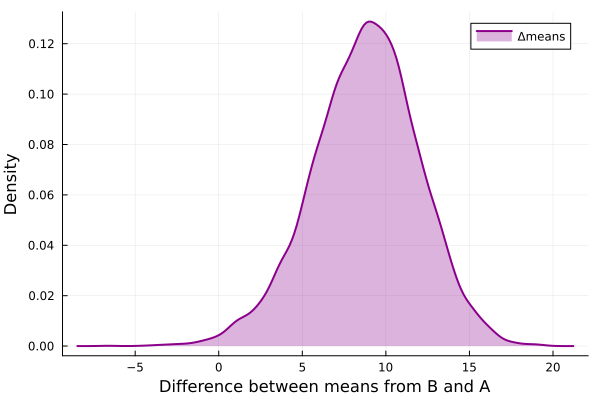

In [29]:
density(Δmeans, ylabel = "Density", xlabel = "Difference between means from B and A", labels = "Δmeans", linewidth = 2, fill = (0, 0.3), color = :darkmagenta)

In [30]:
# Probability that *mean* lifetime from B is greater
sum(mean_b - mean_a .> 0) / length(posterior_sample)


0.99425

In [31]:
# Probability that *mean* lifetime from B is more than 3 hours greater
sum(mean_b - mean_a .> 3) / length(posterior_sample)

0.958125

We see that this probability is around 95% *even though the t-test, which tests differences in the means of samples, said that the difference was non-significant!*. This is how far astray we can be led by dichotomizing into significant and non-significant. When the variances of the samples were not significantly different, we proceeded by pretending they were the same because those were the only alternatives we had: same or different - and according to how classical statistics is often practiced, what is not significant is taken not to exist. Then, after deciding that there was no difference in variance between the two samples, the equal-variance *t*-test also found no significant difference in means, which is again too often taken to mean that such a difference doesn't exist *even though probability theory (i.e., Bayesian inference) tells us that, under plausible assumptions, it is about 95%!*

In any case, the question the *t*-test addresses is not even the most relevant. More relevant than whether the means of the posterior distributions differ is the question how much longer we can expect a random part from B to live than a random part from A. More precisely, we can ask: what is the probability that a part from B lives at least three days longer than a part from A. This can be answered by looking at the posterior predictive distribution.

# Posterior predictive simulation

We simulate standardized log-lifetimes from the posterior predictive distribution by using a design where the observations are missing and only manufacturers 1 and 2 (i.e., A and B) are represented.

In [32]:
posterior_predictive_design = gaussians([missing, missing], [1, 2], 0, 0.5, 0.2)

DynamicPPL.Model{typeof(gaussians), (:y, :c, :α_μ, :α_σ, :θ), (), (), Tuple{Vector{Missing}, Vector{Int64}, Int64, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(gaussians, (y = [missing, missing], c = [1, 2], α_μ = 0, α_σ = 0.5, θ = 0.2), NamedTuple(), DynamicPPL.DefaultContext())

The `predict` function allows us to sample from the posterior predictive distribution by combining the posterior predictive design with the posterior distribution.

In [33]:
posterior_predictive_sample = predict(posterior_predictive_design, posterior_sample)

Chains MCMC chain (8000×2×1 Array{Float64, 3}):

Iterations        = 1:1:8000
Number of chains  = 1
Samples per chain = 8000
parameters        = y[1], y[2]
internals         = 

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        y[1]   -0.2464    0.9344    0.0106   7794.2133   7454.3887    1.0004   ⋯
        y[2]    0.6374    0.5007    0.0059   7463.6212   6818.8485    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        y[1]   -2.1093   -0.8517   -0.2429    0.3497    1.6407
        y[2]   -0.4267    0.3496    0.6591    0.9419    1.5977


Next, we transform to the observation scale and apply visual checks:

In [34]:
# Stack
posterior_predictive_sample_stacked = vec(posterior_predictive_sample.value)

16000-element reshape(::AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, 16000) with eltype Float64:
 -0.4468746862359396
  1.9394858092513774
 -1.2882221686330944
 -2.2692642432924703
 -1.0509739259370845
 -1.5080843690154233
 -0.2983954903830101
  0.36471492051988585
 -0.9584659129828175
 -1.0611628711880314
  ⋮
  0.6837911054232543
  0.9245363678844027
  0.10638298345497849
  0.6351145164433497
  1.171618872739107
  0.7935742104369855
  0.5883486308150103
  0.577345058131262
 -2.095762815804285

In [35]:
# Map to observation space
posterior_predictive_lifetime_stacked = exp.(StatsBase.reconstruct(zed, posterior_predictive_sample_stacked))

16000-element Vector{Float64}:
 40.26776895904084
 66.84425223325255
 33.67872892824182
 27.34444129681371
 35.41916657127444
 32.14227796302879
 41.55780303733621
 47.84259406967053
 36.12192074241836
 35.34260510022025
  ⋮
 51.19703187809608
 53.8827779110284
 45.2884455697609
 50.67048806407315
 56.78579213870099
 52.40474997361058
 50.16971401748601
 50.05260765526733
 28.370827146633168

In [36]:
# Unstack
posterior_predictive_lifetime = reshape(posterior_predictive_lifetime_stacked, (8_000, 2))

8000×2 Matrix{Float64}:
 40.2678  52.5675
 66.8443  47.96
 33.6787  58.611
 27.3444  50.0181
 35.4192  54.8021
 32.1423  50.3077
 41.5578  56.1937
 47.8426  43.5361
 36.1219  51.7589
 35.3426  48.3684
  ⋮       
 42.2939  51.197
 38.3204  53.8828
 45.4903  45.2884
 22.9562  50.6705
 43.4758  56.7858
 51.3759  52.4047
 41.6348  50.1697
 43.4856  50.0526
 59.6159  28.3708

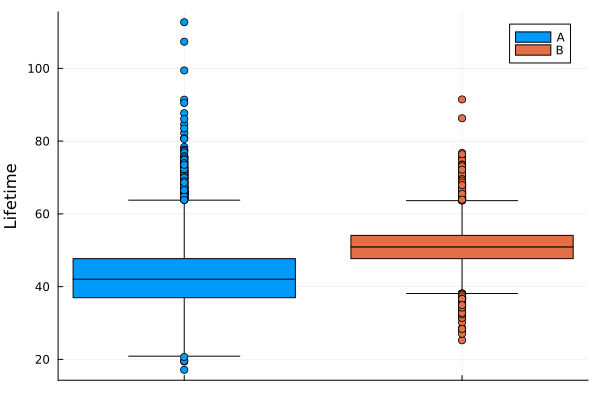

In [37]:
boxplot(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Lifetime", xticks = ([1, 2], ["", ""]))

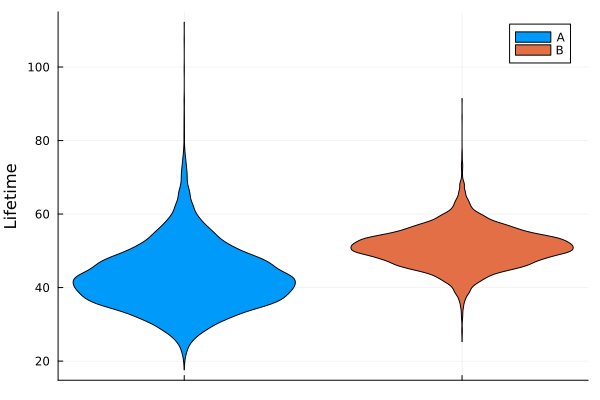

In [38]:
violin(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Lifetime", xticks = ([1, 2], ["", ""]))

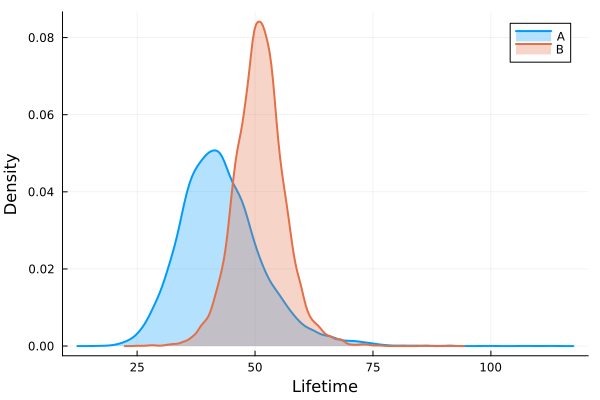

In [39]:
density(posterior_predictive_lifetime, labels = ["A" "B"], ylabel = "Density", xlabel = "Lifetime", linewidth = 2, fill = (0, 0.3))

### Comparison of predicted lifetimes

Finally, we can compare predicted lifetimes.

In [40]:
t_a = posterior_predictive_lifetime[:, 1];
t_b = posterior_predictive_lifetime[:, 2];

In [41]:
Δt = t_b - t_a;

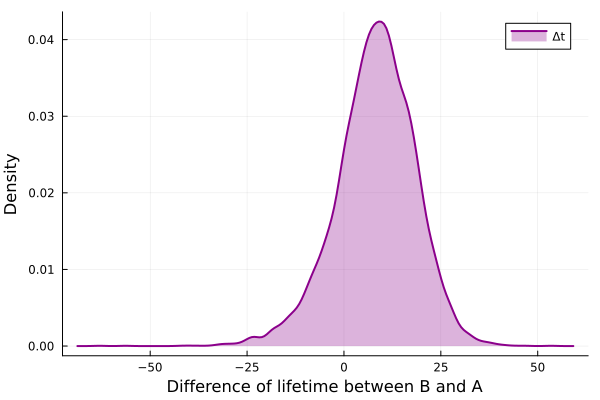

In [42]:
density(Δt, ylabel = "Density", xlabel = "Difference of lifetime between B and A", labels = "Δt", linewidth = 2, fill = (0, 0.3), color = :darkmagenta)

In [43]:
# Probability that when randomly choosing a part from each manufacturer,
# the lifetime of that from B is greater
sum(t_b - t_a .> 0) / length(posterior_predictive_sample)

0.81025

In [44]:
# Probability that when randomly choosing a part from each manufacturer,
# the lifetime of that from B is more than 3 hours greater
sum(t_b - t_a .> 3) / length(posterior_predictive_sample)

0.7225

In conclusion, if a probability of about 70% that parts from B will live at least three days longer than parts from A is good enough for the boss, then he should buy from B.